#### **PyTorch**

In [1]:
import torch
import torch.nn.functional as F
print(f"PyTorch Version: {torch.__version__}")

import torch
print(f"Cude is available: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.3.0+cu121
Cude is available: True
Device name: NVIDIA H100 PCIe


#### **Import Other Libraries**

In [2]:
# Standard library imports
import os

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import DecoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

#### **Parameters**

In [3]:
seed = 0
noise = False 
version = 1 
lr = 1e-4
sample_size = 2000
warmup_ratio = 0.25
batch_size = 8
epochs = 30
patience = 10
gamma = 0.0
prompt = True 
test_size = 0.25

#### **Seed**

In [4]:
np.random.seed(seed)

#### **Set Up Paths**

In [5]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [6]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_24pt/Newsreader_24pt-ExtraBoldItalic.ttf


#### **First Stage Function**

In [7]:
disabilities = [
    "good health",
    "mobility impairments",
    "blindness",
    "deafness",
    "multiple sclerosis",
    "cerebral palsy",
    "severe depression",
    "bipolar disorder",
    "schizophrenia",
    "anxiety disorders",
    "autism",
    "diabetes",
    "heart disease",
    "HIV/AIDS",
    "a major surgery",
    "a severe injury",
    "pneumonia",
    "Post-Traumatic Stress",
    "rehabing from addiction"
]

# List of most severe disabilities
most_severe = [
    "blindness",
    "deafness",
    "multiple sclerosis",
    "cerebral palsy",
    "severe depression",
    "bipolar disorder",
    "schizophrenia",
    "HIV/AIDS",
    "heart disease"
]

# Create a list of (0,1)s
severity_indicator = [1 if disability != 'good health' else 0 for disability in disabilities]

def fstage(var1, var2, var3, var4, var5, var6, var7, var8, var9):
    return .35*(severity_indicator[var5]) + 0.35*var9 + .1

#### **Read in Data**

In [8]:
import re 

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict whether the tenant will be represented in court by a lawyer.\n\n Description:'
string1 = "\n\n Note: The tenant has access to a free lawyer."
string0 = "\n\n Note: The tenant does not have access to a free lawyer."
if prompt:
    string1 += ' But, access to a lawyer does not mean the tenant will be represented in court by a lawyer. Conditional on having access to a free lawyer, tenants with vouchers and disabilities are prioritized over other tenants.'

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4'], 
                                                 row['Var5'],
                                                 row['Var6'],
                                                 row['Var7'],
                                                 row['Var8'],
                                                 row['Var9']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                             string_b + df['Description'] + string1,
                             string_b + df['Description'] + string0)

# Text + Instrument == 1
df['Treated_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string1, axis=1)

# Text + Instrument == 0
df['Control_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string0, axis=1)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + 0.1*np.random.normal(size=sample_size)

#### **Plot**

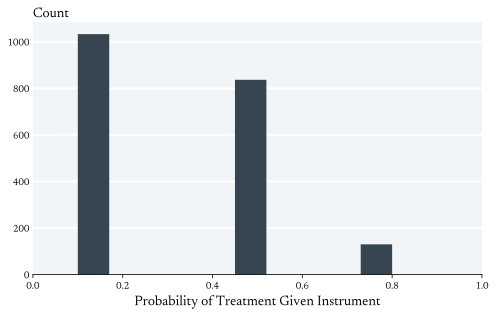

In [9]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

##### **Set Up Device**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Qlora**

In [11]:
from peft import LoraConfig, get_peft_model 
from transformers import BitsAndBytesConfig

# ----- QUANTIZATION -------# 
# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = True

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = True

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# ----- LORA -------# 

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

Your GPU supports bfloat16: accelerate training with bf16=True


#### **Instantiate Model**

In [12]:
model_name = "meta-llama/Meta-Llama-3-8B-Instruct" 
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                             device_map="auto", 
                                             quantization_config=bnb_config, 
                                             trust_remote_code=True)# So we can do gradient checkpointing
model.config.use_cache = True
model.config.pretraining_tp = 1
#model.generation_config.temperature = 0.01
model.enable_input_require_grads()
print(model.generation_config)

model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": [
    128001,
    128009
  ],
  "max_length": 4096,
  "temperature": 0.6,
  "top_p": 0.9
}

trainable params: 20,971,520 || all params: 8,051,232,768 || trainable%: 0.2605
None


#### **Tokenizer**

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
def tokenizer_function(example):
  return tokenizer.apply_chat_template(example["messages"], 
                                                          tokenize=True, 
                                                          add_generation_prompt=False, 
                                                          return_dict=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
# Initialize the dataset list
dataset = []

for index, row in df.iterrows():
    entry = [
        {'content': 'You are a housing court clerk', 'role': 'system'},
        {'content': f"Task: {row['FullDescription']}\n\n    Prediction: ", 'role': 'user'},
        {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
    ]
    dataset.append(entry)

dataset = Dataset.from_dict({'messages': dataset})

In [15]:
to_markdown(dataset['messages'][0][1]['content'])

> Task: Based on the following information, predict whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 42-year-old individual who has been residing in a two-story duplex with a housing voucher for the past 42 months. Despite having good health, they are currently struggling to pay the $1298 rent. The tenant enjoys writing short stories in their free time, finding solace in the creative outlet during these challenging financial times. To help cover the rent, the tenant's family contributes to the monthly payments. Additionally, the tenant finds comfort in the presence of a fish tank, which provides a calming and therapeutic environment amidst the stress of their housing situation.
> 
>  Note: The tenant has access to a free lawyer. But, access to a lawyer does not mean the tenant will be represented in court by a lawyer. Conditional on having access to a free lawyer, tenants with vouchers and disabilities are prioritized over other tenants.
> 
>     Prediction: 

#### **Data Loaders**

In [16]:
def get_input_id(example):
    example['type_indicator'] = 1 if row['Instrument'] == 1 else 0
    return example

dataset = dataset.map(get_input_id, batched=False)
tokenized_dataset = dataset.map(tokenizer_function, batched=True)

tokenized_dataset = tokenized_dataset.remove_columns(['messages'])
tokenized_dataset_split = tokenized_dataset.train_test_split(test_size=test_size, seed=42)
all_loader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
train_loader = DataLoader(tokenized_dataset_split['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
test_loader = DataLoader(tokenized_dataset_split['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

#### **Optimizer**

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler =transformers.optimization.get_linear_schedule_with_warmup(optimizer,int(warmup_ratio*len(train_loader)*epochs), len(train_loader)*epochs)

#### **Class Weights**

In [18]:
class_weights = torch.tensor([1., 1.], device=device) #torch.tensor([1-n_positive/n_samples, n_positive/n_samples], device=device)
# criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='output', reduction='none')
# criterion = torch.nn.CrossEntropyLoss(reduction='mean') 

# # Assume 'class_counts' is a list containing the number of samples for each class
# n_samples = len(dataset['train']); print(f"Number of Observations: {n_samples}")
# n_positive = sum(dataset['train']['type_indicator']); print(f"Number of Positive Outcomes: {n_positive}")
# class_weights = torch.tensor([1., 1.], device=device) 
# frac_positive = (n_positive/n_samples)
# class_weights = torch.tensor([1/ (1-frac_positive), 1 / frac_positive], device=device)
# class_weights = class_weights/sum(class_weights)
criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='input')
print(criterion.gamma)
print(f"Class Weights: {class_weights}")

0.0
Class Weights: tensor([1., 1.], device='cuda:0')


#### **Trainer**

In [19]:
yuri = DecoderTrainer(model,
                    tokenizer,
                    optimizer, 
                    scheduler,
                    criterion, 
                    device, 
                    verbose=False, 
                    threshold=2)

print(yuri.verbose)

False


In [21]:
evaluation_losses = [yuri.evaluate(test_loader)]
training_losses = [yuri.evaluate(train_loader)]
lr_history = [yuri.optimizer.state_dict()['param_groups'][0]['lr']]
recall_history = [yuri.compute_recall(test_loader)]
pbar =  tqdm(range(epochs), desc=f'Epoch: 0, Train Loss: {training_losses[0]:.3f}, Val Loss: {evaluation_losses[0]:.3f},  rYes: {recall_history[0][1]:.3f}')

for epoch in pbar:
    train_loss = yuri.train(train_loader)
    training_losses.append(train_loss)
    val_loss = yuri.evaluate(test_loader)
    evaluation_losses.append(val_loss)
    recall = yuri.compute_recall(test_loader)
    recall_history.append(recall)

    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, rYes: {recall[1]:.3f}')

Epoch: 12, Train Loss: 0.0356, Val Loss: 0.0414, rYes: 0.000:  40%|████      | 12/30 [25:54<38:52, 129.56s/it]  


KeyboardInterrupt: 

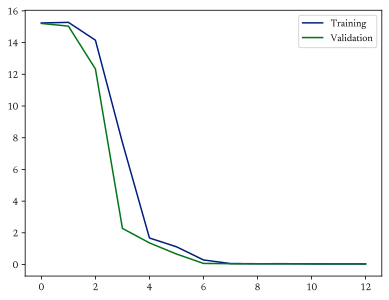

In [22]:
plt.plot(training_losses, label='Training')
plt.plot(evaluation_losses, label='Validation')
plt.legend()
plt.show()

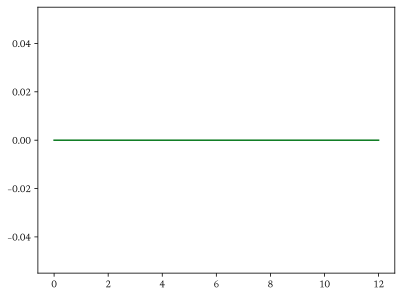

In [23]:
plt.plot([i[0] for i in recall_history])
plt.plot([i[1] for i in recall_history])
plt.show()

In [28]:
import torch

# Fetch the next item
iterator = iter(dataset['messages'])

In [36]:

message = next(iterator)

# Apply tokenization
batch = tokenizer.apply_chat_template(message, tokenize=True, add_generation_prompt=True, return_tensors="pt", return_dict=True).to(device)


# Generate output
generated_outputs = model.generate(
    batch["input_ids"], 
    max_new_tokens=50, 
    do_sample=True, 
    output_scores=True, 
    return_dict_in_generate=True
)

generated_ids = generated_outputs.sequences
decoded = tokenizer.batch_decode(generated_ids, skip_special_tokens=False, max_new_tokens=50)[0]

# Extract the log probabilities
scores = torch.stack(generated_outputs.scores, dim=1)
logprobs = torch.nn.functional.log_softmax(scores, dim=-1)

# Tokenize "No" to ensure correct token ID
no_token_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize("No")[0])

# Check the logprobs for the "No" token ID at each generation step
token_logprobs = logprobs[:, :, no_token_id]

print(f"Log probabilities of 'No': {token_logprobs}")
to_markdown(decoded)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Log probabilities of 'No': tensor([[-inf, -inf, -inf, -inf, -inf, -inf, -inf]], device='cuda:0')


> <|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 31-year-old individual with autism who has been living in a large apartment complex for the past 33 months. They rely on a housing voucher to cover a portion of their $852 monthly rent. Despite the financial assistance, the tenant is currently struggling to make ends meet and keep up with the rental payments. The tenant lives with a roommate who contributes to the rent, which helps alleviate some of the financial burden. In their free time, the tenant volunteers at a local animal shelter, finding solace and meaning in their work with the animals. The tenant's autism presents unique challenges in their daily life, but they navigate these with resilience and determination. The stable housing provided by the apartment complex, though financially strained, has been a crucial component in the tenant's overall well-being and ability to maintain their independence.
> 
>  Note: The tenant has access to a free lawyer. But, access to a lawyer does not mean the tenant will be represented in court by a lawyer. Conditional on having access to a free lawyer, tenants with vouchers and disabilities are prioritized over other tenants.
> 
>     Prediction:<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> Yes<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|>

In [ ]:
generated_outputs = model.generate(
    batch["input_ids"], 
    max_new_tokens=50, 
    do_sample=True, 
    output_scores=True,
    return_dict_in_generate=True
)

In [ ]:
generated_outputs.sequences

In [ ]:
to_markdown(tokenizer.batch_decode(generated_outputs.sequences, skip_special_tokens=True)[0])

In [ ]:
generated_outputs[0]